# Machine Learning
#### Project Overview
The goal of this project is to create a model that predicts whether or not a drug review will have a good rating, based on the review text.

#### Machine Learning Goals
My goals for this step are to:
1. Pre-process features
2. Evaluate and select the best model
3. Improve and tune the selected model
4. Provide insight on feature importance and next steps

## 1. Import

In [120]:
# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')

# machine learning
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# data import/export
from scipy.sparse import load_npz
import pickle

In [2]:
# import dataframe
data = pd.read_pickle('drugsCom_data')

# import term matrix
term_matrix = load_npz('ngram_csr.npz')

# convert term matrix to dataframe
term_matrix = pd.DataFrame(term_matrix.todense())

# import column headers
pickle_in = open('list.pickle', 'rb')
reviews_columns = pickle.load(pickle_in)

# add column headers to term matrix
term_matrix.columns = reviews_columns

## 2. Pre-Processing
Currently, ratings data is still on a scale of 1 to 10. Since our objective is to create a model that can predict a good rating, we'll create a binary rating scale.

During EDA I read through several reviews for each rating and found reviews with ratings 8 and above tended to be good reviews. So we'll replace ratings below 8 with 0 and ratings 8 and above with 1.

In [3]:
# convert rating scale to binary; >= 8 is 1, <8 is 0
replace_values = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:1, 9:1, 10:1}
term_matrix['rating'] = term_matrix.rating.replace(replace_values)

We'll also split our data into train/test splits.

In [4]:
# create arrays for independent features and target
X = term_matrix.drop('rating', axis=1).values
y = term_matrix['rating'].values

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

## 3. Model Selection

### 3.1 Dummy Classifier
I'm going to use a dummy classifier for comparison.

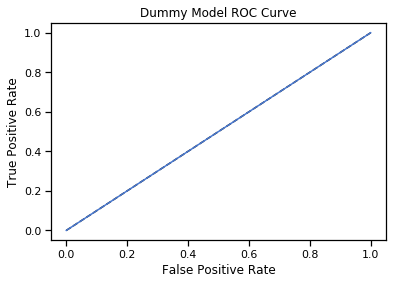

Dummy Model AUC Score: 0.50


In [142]:
# fit and evaluate dummy classifier
dummy_model = DummyClassifier(strategy='most_frequent', random_state=123)

dummy_model.fit(X_train, y_train)

y_pred_prob = dummy_model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Dummy Model ROC Curve')
plt.show()

auc_score = roc_auc_score(y_test, y_pred_prob)

print(f'Dummy Model AUC Score: {auc_score:.2f}')

The dummy classifier had an AUC score of 0.50 and the linear ROC curve you'd expect.

### 3.2 Possible Models
There are several classification algorithms that could be used for our model. I want to see how Naive Bayes, K-Nearest Neighbor, Logistic Regression, Decision Tree, and Random Forest perform. I assume Random Forest will have the best performance being an ensemble method.

In [143]:
# instantiate classifiers
classifiers = {'Naive Bayes': MultinomialNB(),
               'K-Nearest Neighbor': KNeighborsClassifier(),
               'Logistic Regression': LogisticRegression(),
               'Decision Tree': DecisionTreeClassifier(random_state=123),
               'Random Forest': RandomForestClassifier(random_state=123)}

# create a dataframe to store metrics
metrics_df = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

# train models and record metrics
for cls in classifiers:
        model = classifiers[cls].fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        
        fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        
        metrics_df = metrics_df.append({'classifiers':cls,
                                        'fpr': fpr,
                                        'tpr': tpr,
                                        'auc': auc}, ignore_index=True)
        
# set classifier names as index
metrics_df.set_index('classifiers', inplace=True)

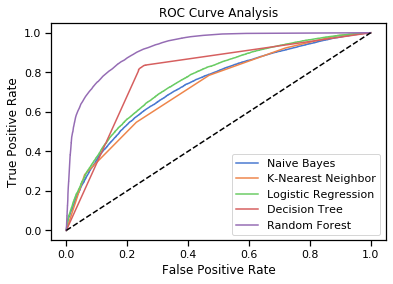

In [179]:
for i in metrics_df.index:
    plt.plot(metrics_df.loc[i]['fpr'],
             metrics_df.loc[i]['tpr'],
             label=f'{i}')
    
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve Analysis')
plt.show()

In [180]:
# print AUC scores
print('AUC Scores')

for i in metrics_df.index.sort_values(''):
    print(f"  {i}: {metrics_df.loc[i]['auc']:.4f}")

AUC Scores
  Decision Tree: 0.7940
  K-Nearest Neighbor: 0.7237
  Logistic Regression: 0.7588
  Naive Bayes: 0.7334
  Random Forest: 0.9248


## 4. Model Tuning
The Random Forest Classifier performed best and achieved an AUC score of 0.92 even with default settings. Let's see if some hyperparameter tuning can improve any better results

In [167]:
# create dictionary of parameterss to evaluate
params = {'n_estimators': [150, 200, 250, 300],
          'max_depth': [40, 60, 80, 100]}

# instantiate and fit GridSearchCV
grid_search = GridSearchCV(estimator=r_forest,
                           param_grid=params)

grid_search.fit(X_train, y_train)

# print best score and parameters
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8223532834978403
{'max_depth': 80, 'n_estimators': 300}


In [10]:
# re-run random forest with best parameters
r_forest = RandomForestClassifier(n_estimators=300,
                                  max_depth=80,
                                  n_jobs=1, 
                                  random_state=123)
cv_results = cross_val_score(r_forest, 
                             X, y, 
                             scoring='roc_auc',
                             cv=5)

print(f'AUC for each fold: {cv_results}')
print(f'Mean AUC: {np.mean(cv_results)}')

AUC for each fold: [0.92945266 0.92456645 0.92926356 0.92874972 0.92746518]
Mean AUC: 0.9278995153465189


## 5. Feature Importance

In [181]:
# fit model
r_forest.fit(X_train, y_train)

# create dataframe with terms and feature importance
feature_importances = pd.DataFrame(r_forest.feature_importances_,
                                   index=term_matrix.drop('rating', axis=1).columns,
                                   columns=['importance']).\
                                   sort_values('importance', ascending=False)

# display feature importances
feature_importances

,importance
year,0.018025
take,0.017617
day,0.016722
work,0.015199
life,0.014344
...,...
alway,0.004050
final,0.004044
around,0.003972
old,0.003894


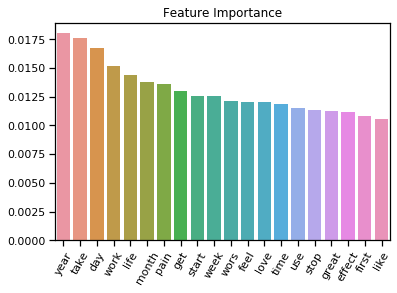

In [177]:
# plot top 20 features
sns.barplot(feature_importances.index[:20], feature_importances['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('')
plt.title('Feature Importance')
plt.show()